In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.io import wavfile

# EDA and Visualization

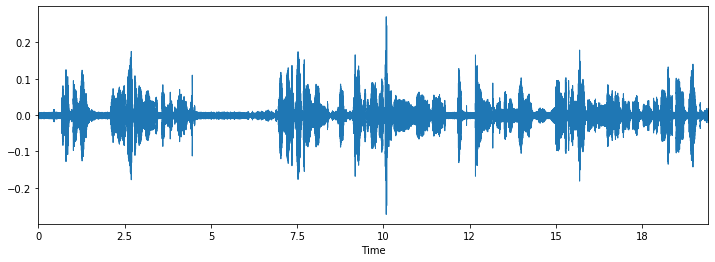

In [2]:
train_audio_path = "dataset/LibriSpeech/train-clean-100/103/1240/"
samples, sample_rate = librosa.load(train_audio_path + "103-1240-0000.flac")
plt.figure(figsize=(12, 4))
librosa.display.waveplot(samples, sr=16000)

In [3]:
ipd.Audio(samples, rate=sample_rate)

In [4]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

**duration of recoding**

In [22]:
import glob
path = train_audio_path + "*.flac"
# records data
voice = glob.glob(path)

(array([ 1.,  0.,  2.,  1.,  2.,  2.,  4.,  9., 27., 10.]),
 array([ 3.81002268,  5.11502041,  6.42001814,  7.72501587,  9.03001361,
        10.33501134, 11.64000907, 12.9450068 , 14.25000454, 15.55500227,
        16.86      ]),
 <a list of 10 Patch objects>)

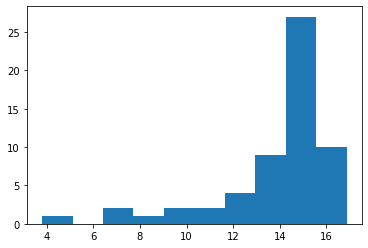

In [24]:
duration_of_recordings = []
for wav in voice:
        samples, sample_rate,  = librosa.load(wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [7]:
def load_def(path):
    # open a txt file as read only
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    return lines

# Preprocessing

In [26]:
# load text lables
lines = load_def("dataset/LibriSpeech/train-clean-100/103/1240/103-1240.trans.txt")
# remove chapter num
labels = [re.sub(r"[^a-zA-Z]+", " ", i).strip() for i in lines]
train_audio_path = "dataset/LibriSpeech/train-clean-100/103/1240/"

all_wave = []
for i in voice:
    samples, sample_rate = librosa.load(i)
    samples = librosa.resample(samples, sample_rate, 8000)
    all_wave.append(samples)

In [27]:
len(labels),len(all_wave)

(58, 58)

In [28]:
# convert output labels to integer encode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(labels)
classes = list(le.classes_)

In [29]:
from keras.utils import np_utils
# onehot encode → it is a multi classification problem
y = np_utils.to_categorical(y, num_classes=len(labels))

In [30]:
# reshape 2d array to 3d, input to the conv1d nust be a 3d array
all_wave = np.array(all_wave).reshape(-1, 58, 1)

**split train and val set**

In [31]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(np.array(all_wave), 
                                                  np.array(y), 
                                                  stratify=y,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  shuffle=True
                                                 )

ValueError: Found input variables with inconsistent numbers of samples: [1, 58]

In [32]:
np.array(all_wave).shape

(1, 58, 1)

In [33]:
np.array(y).shape

(58, 58)